In [ ]:
import requests
import json
import geopandas as gpd
from shapely.geometry import LineString

# Overpass API for URL
url = "https://overpass-api.de/api/interpreter"

# Overpass QL query
query = """
[out:json];
area["name"="San Francisco"]->.sf;
(
  way["highway"](area.sf);
);
out body;
>;
out skel qt;
"""
response = requests.get(url, params={"data": query})

if response.status_code == 200:
    data = response.json()

    # 1. save raw JSON data
    with open("san_francisco_roads.json", "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=4)
    print("raw JSON data has been saved as san_francisco_roads.json")

    # 2. analysis node data
    node_dict = {node["id"]: (node["lon"], node["lat"]) for node in data["elements"] if node["type"] == "node"}

    # 3. analysis road data and convert to GeoDataFrame
    roads = []
    for element in data["elements"]:
        if element["type"] == "way" and "nodes" in element:
            coords = [node_dict[node_id] for node_id in element["nodes"] if node_id in node_dict]
            if coords:
                roads.append(LineString(coords))

    # 4. creat GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry=roads, crs="EPSG:4326")

    # 5. save road data as GeoJSON
    gdf.to_file("san_francisco_roads.geojson", driver="GeoJSON")
    print("Road data has been saved as GeoJSON：san_francisco_roads.geojson")

else:
    print(f"Fail to request, status code：{response.status_code}")


In [ ]:
# This is an optional step, trying to visualize the map
import folium
import geopandas as gpd

gdf = gpd.read_file("san_francisco_roads.geojson") # Please change name to your own file
m = folium.Map(location=[37.7749, -122.4194], zoom_start=12)

# Draw Road
for _, row in gdf.iterrows():
    if row.geometry and row.geometry.geom_type == "LineString":
        folium.PolyLine(
            locations=[(lat, lon) for lon, lat in row.geometry.coords], 
            color="blue", 
            weight=2,  
            opacity=0.7
        ).add_to(m)


folium.LayerControl().add_to(m)
m.save("san_francisco_roads.html")
print("Map has been saved as san_francisco_roads.html")

# Step 2
1. Using QGIS to convert Geojson to Esri shp
2. open the shapefile in Esri ArcGIS Pro
3. Using 'Densify' tool in edit mode
4. Using 'Feature Vectices to Points' tool to convert line to point
5. Using 'Calculate Geometry Attributes' to calculate Lon and Lat
6. Export as .csv file

In [ ]:
from streetview import search_panoramas
import pandas as pd

file_path = r'C:\Users\Tangyuan\Desktop\GSV\SF_road_path.csv'

try:
    df = pd.read_csv(file_path, usecols=[ 'Lon', 'Lat'])
    print(df.head())  # 显示前五行数据以验证读取是否正确
except ValueError as e:
    print(f"读取 CSV 文件时出错：{e}")
except FileNotFoundError:
    print(f"文件未找到：{file_path}")
except Exception as e:
    print(f"发生意外错误：{e}")
    
df.reset_index(inplace=True)
print(df.head(5))

df.to_csv(r'C:\Users\Tangyuan\Desktop\GSV\SF_road_path_index.csv', index=False)

In [ ]:
from streetview import search_panoramas
import os

path = r'C:\Users\Tangyuan\Desktop\GSV\SF_road_path_index.csv'

fw = open(r'SF_panorama_id.csv', 'a', encoding='utf-8')
fw.write('pid,lat,lon,heading,pitch,roll,year,month\n')

# check_already
if not os.path.exists('SF_pid_got.csv'):
    open('SF_pid_got.csv', 'w', encoding='utf-8').close()
ALL_ID = []

# To prevent duplicate downloads
with open('SF_pid_got.csv', 'r', encoding='utf-8') as f:
  for line in f:
    ALL_ID.append(line.strip().split(".")[0])


ALL_DATA = []

n = 0

with open(path, 'r') as f:
    next(f)
    for line in f:
        n += 1
        print(n)
        line_arr = line.strip().split(',')
        xy = [float(line_arr[1]), float(line_arr[2])]
        panoids = search_panoramas(xy[1], xy[0])
        
        for panoid in panoids:
            try:
                xy = [panoid.lon, panoid.lat]
                lat = panoid.lat
                lon = panoid.lon
                pid = panoid.pano_id
                heading = panoid.heading
                pitch = panoid.pitch
                roll = panoid.roll
                date = panoid.date
                if pid in ALL_ID:
                    continue
                else:
                    ALL_ID.append(pid)
                    try:
                        year = date.split('-')[0]
                        month = date.split('-')[1]
                    except:
                        year = "None"
                        month = "None"
                    fw.write('%s,%s,%s,%s,%s,%s,%s,%s\n' % (pid, lat, lon, heading, pitch, roll, year, month))
                    fw2 = open('SF_pid_got.csv', 'a', encoding='utf-8')
                    fw2.write(pid + '\n')

            except:
                print('error')
                continue

In [ ]:
from streetview import search_panoramas
import os
import requests  # 如果想用 requests 的异常

path = r'C:\Users\Tangyuan\Desktop\GSV\SF_road_path_index.csv'

fw = open(r'SF_panorama_id.csv', 'a', encoding='utf-8')

if not os.path.exists('SF_pid_got.csv'):
    open('SF_pid_got.csv', 'w', encoding='utf-8').close()

ALL_ID = []
with open('SF_pid_got.csv', 'r', encoding='utf-8') as f:
    for line in f:
        ALL_ID.append(line.strip().split(".")[0])

start_line = 10797  # 假设从第10053行继续

with open(path, 'r', encoding='utf-8') as f:
    header = next(f)  # 跳过表头
    for line_num, line in enumerate(f, start=2):
        if line_num < start_line:
            continue

        print(f"Processing line {line_num} ...")
        line_arr = line.strip().split(',')
        xy = [float(line_arr[1]), float(line_arr[2])]  # [lon, lat]

        # 为了避免网络错误导致脚本退出，这里进行捕获
        try:
            panoids = search_panoramas(xy[1], xy[0])
        except (requests.exceptions.ConnectionError, ConnectionResetError) as e:
            print(f"Network error at line {line_num}, skipping this row. Error: {e}")
            continue

        except Exception as e:
            print(f"Other error at line {line_num}, skipping. Error: {e}")
            continue

        for panoid in panoids:
            try:
                lat = panoid.lat
                lon = panoid.lon
                pid = panoid.pano_id
                heading = panoid.heading
                pitch = panoid.pitch
                roll = panoid.roll
                date = panoid.date

                if pid in ALL_ID:
                    continue
                ALL_ID.append(pid)

                try:
                    year, month = date.split('-')
                except:
                    year, month = "None", "None"

                fw.write(f"{pid},{lat},{lon},{heading},{pitch},{roll},{year},{month}\n")
                with open('SF_pid_got.csv', 'a', encoding='utf-8') as fw2:
                    fw2.write(pid + '\n')

            except Exception as e:
                print(f"Error on panoid {panoid}: {e}")
                continue

fw.close()
print("Done!")


C:\Users\Tangyuan\AppData\Local\Temp\ipykernel_6208\3506915833.py:6: DtypeWarning: Columns (1,2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Year column distinct values and counts (non-null):
year
2007     5925
2008    26028
2009    17058
2010      324
2011    37011
2012      627
2013    24246
2014    62025
2015    50927
2016    40017
2017    44942
2018    19120
2019    34706
2020    14089
2021    35470
2022    28893
2023    13994
2024     1669
2025      761
Name: count, dtype: int64


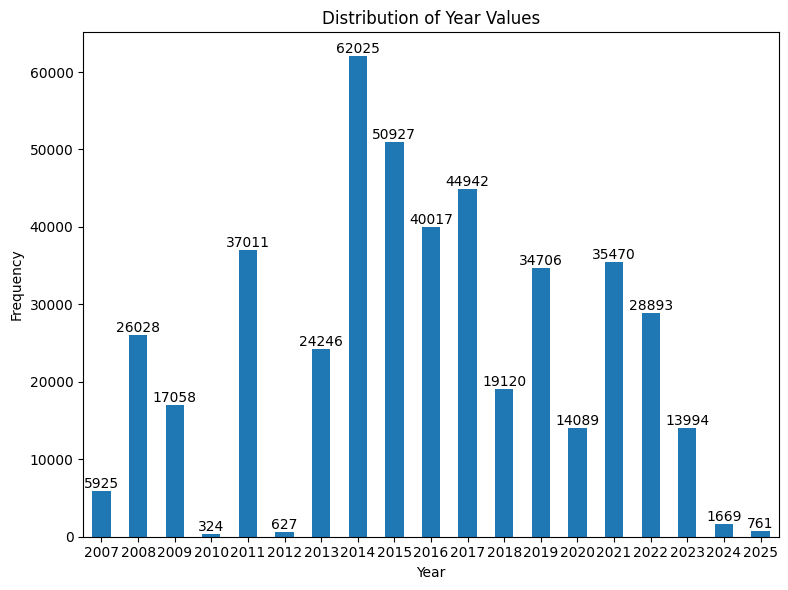

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取CSV
file = r'C:\Users\Tangyuan\Desktop\GSV\pid_dir\SF_panorama_id.csv'
df = pd.read_csv(file)

# 1. 将year列转为数值(非数值变NaN)，再去掉空值，最后转为int
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df = df.dropna(subset=['year'])
df['year'] = df['year'].astype(int)

# 2. 统计year出现频次，并按年序排好
year_counts = df['year'].value_counts().sort_index()

# 3. 打印统计结果
print("Year column distinct values and counts (non-null):")
print(year_counts)

# 4. 绘制柱状图
plt.figure(figsize=(8, 6))
ax = year_counts.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Distribution of Year Values')

# 5. 在柱子上标记出现次数
for patch in ax.patches:
    height = patch.get_height()
    ax.annotate(str(height),
                (patch.get_x() + patch.get_width() / 2, height),
                ha='center', va='bottom')

# 可根据标签多少决定是否旋转，或保持不旋转
plt.xticks(rotation=0)

# 减少重叠
plt.tight_layout()
plt.show()


In [15]:
import pandas as pd

# 绝对路径到 CSV 文件的目录
input_file = r'C:\Users\Tangyuan\Desktop\GSV\pid_dir\SF_panorama_id.csv'
output_file = r'C:\Users\Tangyuan\Desktop\GSV\pid_dir\SF_panorama_id0.csv'

# 需要保留的 pid 列表
pids = [
    'w7uiDgxxKg1kPbA8y1iZjQ',
    'KDDz0M_V6Wey2LDpfcPdng',
    'cFM097j85ur5BFwE5mh41A',
    '1DC0g-VEwiyTlSCz9a2frg',
    'VizR_42JlkWJ-mOSgo_GPQ',
    'KQzHwNoXK40WcvSlWB_ESg',
    'sE5KvqqgLXQ6at1HoCRThQ',
    'wlofjf5TFQymmPIZSveZMA'
]

# 读取CSV文件
df = pd.read_csv(input_file, encoding='utf-8')

# 筛选出 pid 在指定列表中的行
df_filtered = df[df['pid'].isin(pids)]

# 将筛选结果保存为新CSV文件
df_filtered.to_csv(output_file, index=False, encoding='utf-8')
